# Researching, Developing, and Testing "-Ness" Scores

In [2]:
import vco
import numpy as np
#import numpy.ma as ma
import numpy.random as nprd
import matplotlib.pyplot as plt

from scipy.signal                import correlate2d
from scipy.ndimage.interpolation import rotate

%matplotlib inline

In [3]:
from skimage import io, filters
from skimage.feature import blob_dog, blob_log, blob_doh

## Gridness Score
First, we develop the gridness score based on pre-existing methods. This score definitionally prioritizes the $60^{\circ}$, hexagonal grid system. This gridness score is based on [Sargolini _et al._, 2006](http://science.sciencemag.org/content/312/5774/758) (see supplementary materials). The autocorrelogram of the spatial firing rate map is cross-correlated with itself rotated by some regular $\theta$. The gridness score is the difference between the minimum Pearson coefficient at $60^{\circ}$ or $120^{\circ}$ (where the value should peak for a grid cell) and the maximum at $30^{\circ}$, $90^{\circ}$, or $150^{\circ}$ (where the value should be minimal). Cells with a gridness score $G>0$ may be considered grid cells. 

Sargolini _et al._ further specify their scoring paradigm by removing the central peak of the autocorrelogram from the cross-correlation and only considering a circle drawn around the remaining central six peaks. (The implementation below does _not_ include these specifications; the center removal is commented out.)

In [4]:
def center_remove(autocorr):
    only_one = False
    thresh = 1

    while not only_one:
        blobs_log = blob_log(autocorr, max_sigma=100, num_sigma=30, threshold=thresh)

        if (blobs_log.shape[0] == 1):
            only_one = True
        elif (blobs_log.shape[0] < 1):
            thresh = thresh / 1.5
        else:
            thresh = thresh * 2

    # Compute radii in the 3rd column.
    blobs_log[:, 2] = blobs_log[:, 2] * np.sqrt(2)

    xshape, yshape = autocorr.shape
    xc, yc, r = blobs_log[0,:]
    x, y = np.meshgrid(np.arange(xshape), np.arange(yshape))
    d2 = (x - xc)**2 + (y - yc)**2
    mask = d2 < r**2
    autocorr_copy = np.copy(autocorr)
    autocorr_copy[mask] = 0
    return autocorr_copy

In [5]:
def gridness_score(rate_map, theta=6, mask=False, verbose=False):
    autocorr = correlate2d(rate_map,rate_map,mode='full')
    
    # Removing center of autocorrelation
    if mask:
        autocorr = center_remove(autocorr)

    if theta == 0:
        angles = np.array([30, 60, 90, 120, 150])
        trough_idx = np.array([0,2,4])
        peak_idx = np.array([1,3])
    else:
        angles = np.arange(0, 180 + theta, theta)
        trough_idx = np.array([30/theta, 90/theta, 150/theta], dtype=int)
        peak_idx  = np.array([60/theta, 120/theta], dtype=int)
        
    crosscorr = np.zeros(angles.shape)
    for i, angle in enumerate(angles):
        rot_autocorr = rotate(autocorr, angle, reshape=False)
        R = np.corrcoef(np.reshape(autocorr, (1, autocorr.size)),
            np.reshape(rot_autocorr, (1, rot_autocorr.size)))
        crosscorr[i] = R[0,1]

    max_trough = np.max(crosscorr[trough_idx])
    min_peak = np.min(crosscorr[peak_idx])
    gridness = min_peak - max_trough
    
    if verbose:
        plt.figure()
        plt.subplot(131); plt.gca().set_title('Rate Map'); plt.imshow(rate_map); 
        plt.subplot(132); plt.gca().set_title('Autocorrelogram'); plt.imshow(autocorr);
        plt.subplot(133); plt.gca().set_title('Spatial Periodicity'); plt.plot(angles, crosscorr);
        plt.tight_layout()
        print('Gridness score = {}'.format(gridness))
    
    return gridness, crosscorr, angles

### Demonstrating Gridness Method

In [6]:
# Initializing VCO matrix
numrow, numcol = 6, 12
ringsize = 12
minrho = 0.14
rotation_angle = 0
rhos = minrho * (np.sqrt(3)**(np.arange(numrow)))
thetas = np.pi + rotation_angle + 2*np.pi*(np.arange(numcol))/numcol
phz_noise = 0

VCOmat = [[vco.VCO_model(ringsize, rhos[i], thetas[j], phz_noise) \
           for j in range(numcol)] for i in range(numrow)]

In [7]:
# Creating randomized grid cells
n_mats = 50
hexGrid = True

n_inputs = 3
arena = 10
w_grid = np.full([numrow,numcol,n_mats], np.nan)

for mat in range(n_mats):
    rand_row = nprd.randint(numrow)
    if hexGrid:
        rand_col = nprd.randint(4)
        cols = np.array([rand_col, rand_col+4, rand_col+8])
    else:
        cols = np.arange(numcol)
        nprd.shuffle(cols)

    for col in cols[:n_inputs]:
        w_grid[rand_row, col, mat] = nprd.randint(ringsize)

grids = np.zeros([10*arena, 10*arena, n_mats, 2])
for i in range(n_mats):
    grids[:,:,i,0], grids[:,:,i,1] = vco.theta_to_hcn(VCOmat, w_grid[:,:,i], arena)

In [8]:
gridnesses = np.zeros([n_mats,1])
crosscorrs = np.zeros([n_mats,5])

for i in range(n_mats):
    gridnesses[i], crosscorrs[i,:], _ = gridness_score(grids[:,:,i,0], theta=0, mask=True)

[ 0.74748727]


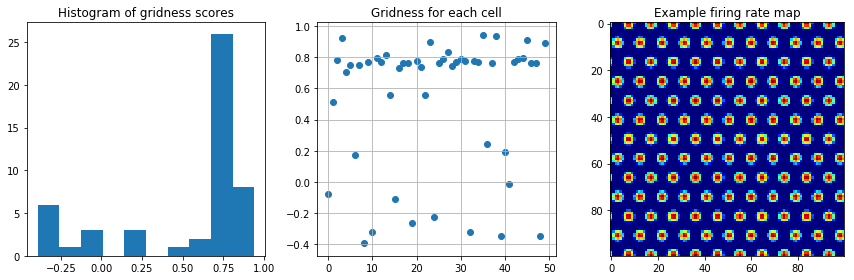

In [9]:
ex_idx = 5
example = grids[:,:,ex_idx,0]
print(gridnesses[ex_idx])

fig = plt.figure(figsize=(12,4))
ax1 = plt.subplot(131)
ax1.hist(gridnesses)
ax1.set_title('Histogram of gridness scores')
ax2 = plt.subplot(132)
ax2.set_title('Gridness for each cell')
ax2.grid()
ax2.scatter(np.arange(n_mats),gridnesses)
ax3 = plt.subplot(133)
ax3.imshow(example,cmap='jet')
ax3.set_title('Example firing rate map')
plt.tight_layout()

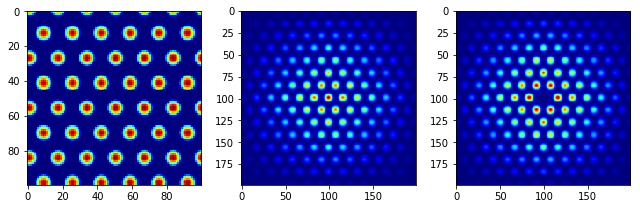

In [14]:
autocorr = correlate2d(example,example,mode='full')
# Removing center of autocorrelation
masked = center_remove(autocorr)
plt.figure(figsize=(9,3))
plt.subplot(131); plt.imshow(example, cmap='jet')
plt.subplot(132); plt.imshow(autocorr, cmap='jet')
plt.subplot(133); plt.imshow(masked, cmap='jet')
plt.tight_layout()

## Placeness Score
There is not a well-defined "placeness" score in the neuroscientific literature. So we will define such a score through experimentation. First, we will experiment with the autocorrelation of a place cell and a non-place cell.

In [15]:
place_weights = np.full([6,12],np.nan)
place_weights[2,:] = [11,11,0,0,0,0,0,0,11,10,10,10]
place_weights[3,:] = [10,11,0,0,0,0,0,0,10,10,10,10]
place_weights[4,:] = [10,11,0,1,2,1,0,0,10, 9, 8, 9]

In [16]:
arena = 5
pplace = np.zeros([arena*10, arena*10, 2])
pplace[:,:,0], pplace[:,:,1] = vco.theta_to_hcn(VCOmat, place_weights, arena)
autocorr_pp = correlate2d(pplace[:,:,0],pplace[:,:,0])

In [17]:
bplace_weights = np.full([6,12],np.nan)
bplace_weights[2,:] = [8,0,1,1,7,4,2,7,8,8,4,2]
bplace_weights[3,:] = [3,0,3,0,5,0,1,4,5,9,9,11]
bplace_weights[4,:] = [0,2,2,10,7,0,0,5,6,2,6,4]

bplace = np.zeros([arena*10, arena*10, 2])
bplace[:,:,0], bplace[:,:,1] = vco.theta_to_hcn(VCOmat,bplace_weights,arena)
autocorr_bp = correlate2d(bplace[:,:,0],bplace[:,:,0])

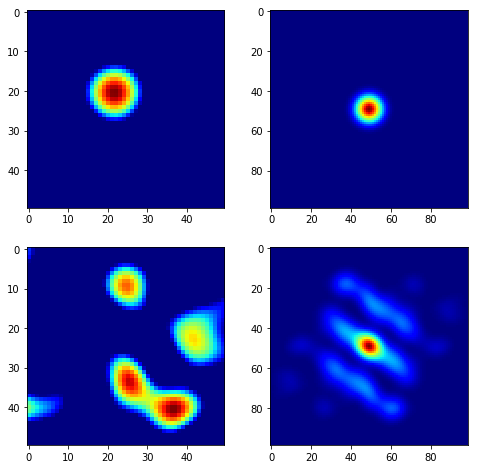

In [18]:
plt.figure(figsize=(8,8))
plt.subplot(221); plt.imshow(pplace[:,:,0],cmap='jet')
plt.subplot(222); plt.imshow(autocorr_pp,cmap='jet')
plt.subplot(223); plt.imshow(bplace[:,:,0], cmap='jet')
plt.subplot(224); plt.imshow(autocorr_bp, cmap='jet')

In [19]:
print('Mean of PC autocorrelation: {}'.format(np.mean(autocorr_pp)))
print('Mean of non-PC autocorrelation: {}'.format(np.mean(autocorr_bp)))

Mean of PC autocorrelation: 0.618747117579556
Mean of non-PC autocorrelation: 6.564612333695351


In [20]:
autocorr_pp_masked = center_remove(autocorr_pp)
autocorr_bp_masked = center_remove(autocorr_bp)

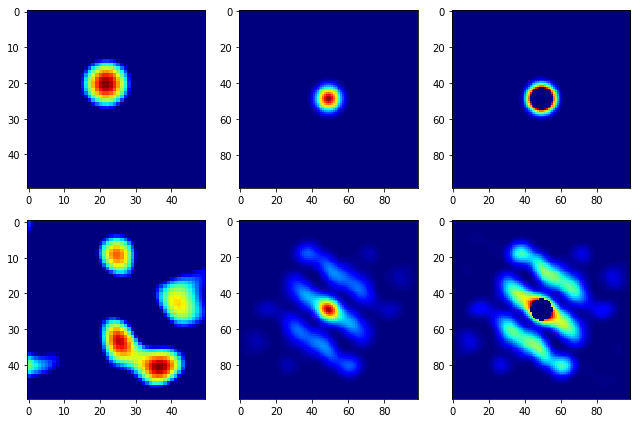

In [21]:
plt.figure(figsize=(9,6))
plt.subplot(231); plt.imshow(pplace[:,:,0],cmap='jet')
plt.subplot(232); plt.imshow(autocorr_pp,cmap='jet')
plt.subplot(233); plt.imshow(autocorr_pp_masked,cmap='jet')
plt.subplot(234); plt.imshow(bplace[:,:,0], cmap='jet')
plt.subplot(235); plt.imshow(autocorr_bp,cmap='jet')
plt.subplot(236); plt.imshow(autocorr_bp_masked, cmap='jet')
plt.tight_layout()

In [22]:
print('Mean of PC autocorrelation: {}'.format(np.mean(autocorr_pp_masked)))
print('Mean of non-PC autocorrelation: {}'.format(np.mean(autocorr_bp_masked)))

Mean of PC autocorrelation: 0.21339016993715038
Mean of non-PC autocorrelation: 5.462486324570868


In [24]:
ppg, _, _ = gridness_score(pplace[:,:,0])
bpg, _, _ = gridness_score(bplace[:,:,0])

In [25]:
print('Gridness score of PC: {}'.format(ppg))
print('Gridness score of non-PC: {}'.format(bpg))

Gridness score of PC: -2.7881053464851036e-06
Gridness score of non-PC: 0.01220860638995891


This gives us some information - the closer the mean is to zero, the more place-like the firing map. However, this doesn't allow  us to easily compare different firing maps to each other. The next step should be to create a normalized scale so that maps can be compared.

### Testing LoG/DoG central blob detection

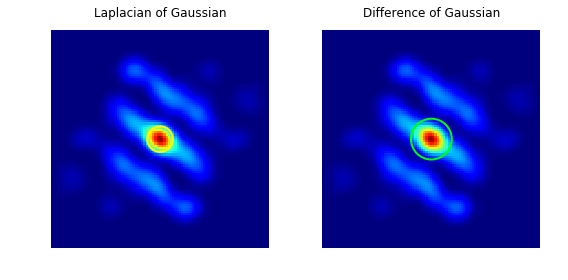

32


In [66]:
image = autocorr_bp
multiple = True
thresh = 1

while multiple:
    blobs_log = blob_log(image, max_sigma=10, num_sigma=30, threshold=thresh)
    blobs_dog = blob_dog(image, max_sigma=10, threshold=thresh)

    if (blobs_dog.shape[0] == 1):# and (blobs_dog.shape[0] == 1):
        multiple = False
    elif (blobs_dog.shape[0] < 1):
        thresh = thresh / 1.5
        
    else:
        thresh = thresh * 2

# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * np.sqrt(2)
blobs_dog[:, 2] = blobs_dog[:, 2] * np.sqrt(2)

blobs_list = [blobs_log, blobs_dog]
colors = ['yellow', 'lime', 'red']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian']
sequence = zip(blobs_list, colors, titles)

fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax = axes.ravel()

for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(image, interpolation='nearest',cmap='jet')
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

plt.tight_layout()
plt.show()
print(thresh)

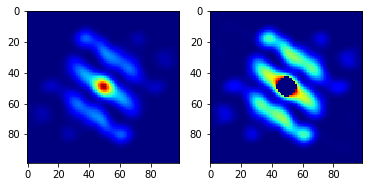

In [67]:
plt.subplot(121); plt.imshow(autocorr_b,cmap='jet')
plt.subplot(122); plt.imshow(autocorr_b_masked,cmap='jet')

In [68]:
print('Mean of masked autocorrelagram: {}'.format(np.mean(autocorr_b_masked)))

Mean of masked autocorrelagram: 5.46248632457087


In [70]:
maxac = np.max(autocorr_b)
normac = autocorr_b_masked / maxac
print('Mean of normalized masked AC: {}'.format(np.mean(normac)))

Mean of normalized masked AC: 0.03868883193985332
